In [1]:
import pandas as pd
import pyproj
from shapely.geometry import Point
from shapely.ops import transform
import numpy as np

In [2]:
df = pd.read_csv('OD_matrix_201803.csv',encoding='unicode_escape')

<AxesSubplot:xlabel='X_start', ylabel='Y_start'>

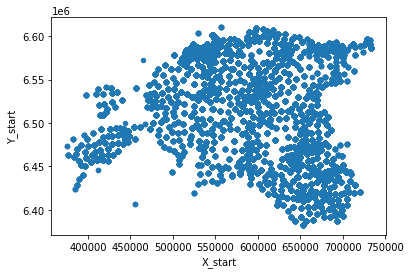

In [3]:
df.plot.scatter('X_start','Y_start')

It is similar to the map of Estonia, but the projection is a bit  weird. At least it is not `4326` nor `3857`. It is in the local projection of `3300`.

In [4]:
df

,KANT_start,KANT_end,start_kant_id,end_kant_id,X_start,Y_start,X_end,Y_end,route_id,Population,RegularMovers
0,Aakre Valga,Aakre Valga,1,1,627213.008799,6.440209e+06,627213.008799,6.440209e+06,1697,470,96
1,Aakre Valga,Annikoru Tartu,1,25,627213.008799,6.440209e+06,634298.193717,6.461856e+06,21178,470,1
2,Aakre Valga,Elva linn,1,49,627213.008799,6.440209e+06,642136.014361,6.456563e+06,41506,470,12
3,Aakre Valga,Elva ümbruse kant Tartu,1,50,627213.008799,6.440209e+06,639265.501560,6.453032e+06,42353,470,1
4,Aakre Valga,Hellenurme Valga,1,81,627213.008799,6.440209e+06,640178.641901,6.447022e+06,68610,470,2
...,...,...,...,...,...,...,...,...,...,...,...
28504,Ülenurme Tartu,Võnnu Tartu,839,810,659202.938891,6.468463e+06,681155.798401,6.464204e+06,686062,4959,6
28505,Ülenurme Tartu,Võru linn,839,812,659202.938891,6.468463e+06,678417.528347,6.414736e+06,687756,4959,6
28506,Ülenurme Tartu,Võõpste Tartu,839,816,659202.938891,6.468463e+06,683260.892473,6.473663e+06,691144,4959,1
28507,Ülenurme Tartu,Välgi Tartu,839,823,659202.938891,6.468463e+06,669844.459691,6.497459e+06,697073,4959,1


In [5]:
len(df.KANT_start.unique())

845

In [6]:
len(df.KANT_end.unique())

844

In [7]:
set(df.KANT_start.unique()) - set(df.KANT_end.unique())

{'Vilsandi Saare'}

In [8]:
set(df.KANT_end.unique()) - set(df.KANT_start.unique())

set()

Then, the `KANT_start.unique()` has all the locaions we need to transform their prrojection.

In [9]:
start = df.groupby('KANT_start').first()

In [10]:
start

,KANT_end,start_kant_id,end_kant_id,X_start,Y_start,X_end,Y_end,route_id,Population,RegularMovers
KANT_start,,,,,,,,,,
Aakre Valga,Aakre Valga,1,1,627213.008799,6.440209e+06,627213.008799,6.440209e+06,1697,470,96
Aardla Tartu,Aardla Tartu,2,2,664206.080560,6.466176e+06,664206.080560,6.466176e+06,2545,1087,239
Aarna Põlva,Aarna Põlva,3,3,674944.509786,6.441704e+06,674944.509786,6.441704e+06,3393,243,19
Aaspere Lääne-Viru,Aaspere Lääne-Viru,4,4,620838.092143,6.592462e+06,620838.092143,6.592462e+06,4241,441,173
Abja Viljandi,Abja-Paluoja linn,6,5,579178.093070,6.441166e+06,579742.050531,6.444023e+06,5090,564,154
...,...,...,...,...,...,...,...,...,...,...
Ääsmäe Harju,Aruküla Harju,837,34,529187.870955,6.566963e+06,561079.126772,6.580363e+06,29635,1266,2
Õisu Viljandi,Abja-Paluoja linn,832,5,588943.147572,6.452916e+06,579742.050531,6.444023e+06,5914,455,19
Õru Valga,Aakre Valga,833,1,627647.829537,6.423045e+06,627213.008799,6.440209e+06,2527,354,1


In [11]:
def transformer(x,y):
    EPSG_3300 = pyproj.CRS('EPSG:3300')
    EPSG_4326 = pyproj.CRS('EPSG:4326')


    project = pyproj.Transformer.from_crs(EPSG_3300, EPSG_4326, always_xy=True).transform
    EPSG_4326_point = transform(project, Point(x,y))
    return (EPSG_4326_point.x,EPSG_4326_point.y)

In [12]:
start_locations  = list(map(transformer,start.X_start,start.Y_start))

In [13]:
start_locations_array = np.array(start_locations)
start_locations_array
lngs = start_locations_array[:,0]
lats = start_locations_array[:,1]

In [14]:
start_points = dict(zip(start.index.values,start_locations))

In [15]:
stdf = pd.DataFrame(zip(start.index.values,lngs,lats),columns=['name','lng','lat'])
stdf.to_csv('points.csv',index=False)

In [16]:
stdf

,name,lng,lat
0,Aakre Valga,26.156788,58.084661
1,Aardla Tartu,26.801715,58.305377
2,Aarna Põlva,26.966251,58.081711
3,Aaspere Lääne-Viru,26.130749,59.452678
4,Abja Viljandi,25.342999,58.104500
...,...,...,...
840,Ääsmäe Harju,24.511392,59.240014
841,Õisu Viljandi,25.513075,58.208101
842,Õru Valga,26.154810,57.930509
843,Üdruma Lääne,24.056365,58.800669


**Lets only visualize most important connections to have a cleaner visualization.**

In [17]:
df = df.sort_values(['KANT_start','RegularMovers'],ascending=False)

In [18]:
sample_od = df.groupby(['KANT_start']).head(5)

In [19]:
sample_od

,KANT_start,KANT_end,start_kant_id,end_kant_id,X_start,Y_start,X_end,Y_end,route_id,Population,RegularMovers
28508,Ülenurme Tartu,Ülenurme Tartu,839,839,659202.938891,6.468463e+06,659202.938891,6.468463e+06,710625,4959,2073
28487,Ülenurme Tartu,Tartu linn,839,673,659202.938891,6.468463e+06,659624.726363,6.473200e+06,570023,4959,2025
28475,Ülenurme Tartu,Reola Tartu,839,559,659202.938891,6.468463e+06,658306.155420,6.463911e+06,473465,4959,262
28479,Ülenurme Tartu,Räni Tartu,839,582,659202.938891,6.468463e+06,655237.976470,6.471162e+06,492946,4959,68
28434,Ülenurme Tartu,Külitse Tartu,839,303,659202.938891,6.468463e+06,654189.346667,6.467502e+06,256633,4959,64
...,...,...,...,...,...,...,...,...,...,...,...
27,Aakre Valga,Puka Valga,1,515,627213.008799,6.440209e+06,629654.751850,6.434822e+06,435361,470,138
0,Aakre Valga,Aakre Valga,1,1,627213.008799,6.440209e+06,627213.008799,6.440209e+06,1697,470,96
31,Aakre Valga,Rõngu Tartu,1,579,627213.008799,6.440209e+06,632067.794181,6.447812e+06,489569,470,77
36,Aakre Valga,Tartu linn,1,673,627213.008799,6.440209e+06,659624.726363,6.473200e+06,569187,470,26


In [20]:
def substiute(st,nd):
    st_lng = start_points[st][0]
    st_lat = start_points[st][1]
    nd_lng = start_points[nd][0]
    nd_lat = start_points[nd][1]

    return st_lng, nd_lng, st_lat, nd_lat

In [21]:
sample_od.KANT_end

28508     Ülenurme Tartu
28487         Tartu linn
28475        Reola Tartu
28479         Räni Tartu
28434      Külitse Tartu
              ...       
27            Puka Valga
0            Aakre Valga
31           Rõngu Tartu
36            Tartu linn
26       Pikasilla Valga
Name: KANT_end, Length: 4202, dtype: object

In [22]:
ndf = pd.DataFrame(map(substiute,sample_od.KANT_start,sample_od.KANT_end),columns=['start_lon','end_lon','start_lat','end_lat'])
ndf['start'] = sample_od.KANT_start.values
ndf['end'] = sample_od.KANT_end.values
ndf

,start_lon,end_lon,start_lat,end_lat,start,end
0,26.718025,26.718025,58.327739,58.327739,Ülenurme Tartu,Ülenurme Tartu
1,26.718025,26.728505,58.327739,58.370076,Ülenurme Tartu,Tartu linn
2,26.718025,26.699604,58.327739,58.287223,Ülenurme Tartu,Reola Tartu
3,26.718025,26.652224,58.327739,58.353372,Ülenurme Tartu,Räni Tartu
4,26.718025,26.631874,58.327739,58.320906,Ülenurme Tartu,Külitse Tartu
...,...,...,...,...,...,...
4197,26.156788,26.195169,58.084661,58.035601,Aakre Valga,Puka Valga
4198,26.156788,26.156788,58.084661,58.084661,Aakre Valga,Aakre Valga
4199,26.156788,26.243347,58.084661,58.151458,Aakre Valga,Rõngu Tartu
4200,26.156788,26.728505,58.084661,58.370076,Aakre Valga,Tartu linn


In [23]:
alng = np.array(ndf.iloc[:,:2])
alat = np.array(ndf.iloc[:,2:4])

In [24]:
rlng = alng.reshape(-1)
rlat = alat.reshape(-1)

In [25]:
names = []
start_counts = ndf.groupby('start')['end'].count()
for c, name in zip(start_counts,ndf.start.values):
    names.append([name] * 2*c)


In [26]:
from itertools import chain
names = list(chain(*names))

In [27]:
len(names) , len(rlat)

(8404, 8404)

In [28]:
od_series = pd.DataFrame(zip(rlng,rlat,names),columns=['lon','lat','locations'])

In [32]:
import plotly.express as px

fig = px.line_mapbox(od_series, lat="lat", lon="lon", color="locations", zoom=3, height=300)

fig.update_layout(mapbox_style="stamen-terrain", mapbox_zoom=6, mapbox_center_lat = 58,
    margin={"r":0,"t":20,"l":0,"b":0},height=1200, width=1600,)

fig.show()

In [30]:
od_series.to_csv('Estonia_od_serie.csv',index=False)

In [31]:
# 2728190.4136,8255886.9881,2776498.6154,8288143.4140 Tallinn
